<a href="https://colab.research.google.com/github/MosheWasserb/BestPracticeTextClassificationDistillation/blob/main/Distill_Blog_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init

In [ ]:
# All the following code lines should be un-masked to allow
#traininng transformers (with ktrain+HuggingFace) and/or generating pseudo labels 

#!pip install ktrain
#import ktrain
#from ktrain import text

#def ModelTransformer(model_name, categories,max_len, epochs, batch_size):

#  t = text.Transformer(model_name, maxlen=max_len, class_names=categories)   
#  trn = t.preprocess_train(x_train, y_train)
#  val = t.preprocess_test(x_test, y_test)
#  model = t.get_classifier()
#  learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=batch_size) 
#  learner.fit_onecycle(2e-5, epochs)
#  return(learner, t)

In [49]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
### read data from your Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, GlobalAveragePooling1D, Dense, Input, Conv1D, MaxPooling1D, Dropout
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score,classification_report
from matplotlib import pyplot as plt
import tensorflow as tf

import pickle
def convert_to_pickle(item, directory):
    pickle.dump(item, open(directory,"wb"))
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

seed(42)

In [ ]:
def Tokenizer_Padding(max_num_words,maxlen, X_train,X_test): 

  oov_token = '<UNK>' # Required only if test is not given 
  pad_type = 'post'
  trunc_type = 'post'

# Tokenize our training data
  tokenizer = Tokenizer(num_words=max_num_words, oov_token = '<UNK>')
  tokenizer.fit_on_texts(X_train)

# Encode training data sentences into sequences
  train_sequences = tokenizer.texts_to_sequences(X_train)

# Pad the training sequences
  train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

# Encode test data sentences into sequences and padding
  test_sequences = tokenizer.texts_to_sequences(X_test)
  test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

  return(train_padded, test_padded)

In [ ]:
def ModelArch(max_num_words, max_len, num_class, model_type, embedding_dim):

  if model_type=='CBOW':
    model = Sequential()
    model.add(Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_len,trainable=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(embedding_dim, activation='relu'))
    model.add(Dense(num_class, activation='softmax')) 
 
  model.compile(optimizer='adam', loss='KLD',metrics=['accuracy'])

  return(model)

In [ ]:
def ModelProcess(train_padded,test_padded, y_train_hotvec,epochs,model):

  callbacks_list = [
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', mode='max', save_best_only=True, verbose=0),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]

  history = model.fit(
    train_padded,
    y_train_hotvec,  
    epochs=epochs,
    batch_size=512,
    validation_split=0.1,
    shuffle=True,
    verbose=0,
    callbacks=callbacks_list)
  
  saved_model = load_model('best_model.h5')
  logits_pred = saved_model.predict(test_padded, batch_size=64, verbose=1)
  y_pred_bool = np.argmax(logits_pred, axis=1)


  return(y_pred_bool, history, saved_model)

# Blog 1/3

Load emotion dataset from HuggingFace

In [ ]:
!pip install datasets
from datasets import load_dataset
emotion_dataset = load_dataset('emotion')

train_df = pd.DataFrame(list(zip(emotion_dataset['train']['text'], emotion_dataset['train']['label'])), 
               columns =['text', 'label'])

test_df = pd.DataFrame(list(zip(emotion_dataset['test']['text'], emotion_dataset['test']['label'])), 
               columns =['text', 'label'])

x_train = train_df.text.values
y_train = train_df.label.values

x_test =  test_df.text.values
y_test = test_df.label.values


value2hot = {
  0: [1,0,0,0,0,0],
  1: [0,1,0,0,0,0],
  2: [0,0,1,0,0,0],
  3: [0,0,0,1,0,0],
  4: [0,0,0,0,1,0],
  5: [0,0,0,0,0,1]
}

y_train_hotvec = np.array([value2hot[l] for l in y_train])

1st  step: Set a baseline using MLP and logistic regression model (TfIdf based)

In [ ]:
# sklearn's MLP (TfIdf based)
from sklearn.neural_network import MLPClassifier, MLPRegressor
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), MLPClassifier(random_state=1,early_stopping=True,hidden_layer_sizes=(16))).fit(x_train, y_train)
predicted = model.predict(x_test)
print(accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

0.861
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       581
           1       0.85      0.93      0.89       695
           2       0.81      0.66      0.73       159
           3       0.87      0.85      0.86       275
           4       0.84      0.75      0.80       224
           5       0.80      0.56      0.66        66

    accuracy                           0.86      2000
   macro avg       0.84      0.78      0.81      2000
weighted avg       0.86      0.86      0.86      2000



In [ ]:
# sklear's' Logistic (TfIdf based)
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1)), LogisticRegression(max_iter=200)).fit(x_train, y_train)
predicted = model.predict(x_test)
print(accuracy_score(y_test, predicted))
print(classification_report(y_test, predicted))

0.861
0.8145907734621154
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.83      0.96      0.89       695
           2       0.82      0.58      0.68       159
           3       0.90      0.81      0.85       275
           4       0.87      0.78      0.82       224
           5       0.84      0.47      0.60        66

    accuracy                           0.86      2000
   macro avg       0.86      0.75      0.79      2000
weighted avg       0.86      0.86      0.86      2000



2nd step: Deep Learning baseline

In [ ]:
NUM_CLASS = 6
MAX_NUM_WORDS = 5000
MAX_LEN = 64 
EPOCHS = 100
EMBEDDING_DIM=16

In [ ]:
#Tokenization
train_padded, test_padded = Tokenizer_Padding(MAX_NUM_WORDS, MAX_LEN, x_train,x_test)

In [ ]:
model = ModelArch(MAX_NUM_WORDS, MAX_LEN, NUM_CLASS, 'CBOW', EMBEDDING_DIM)
y_pred_bool, history, saved_model = ModelProcess(train_padded,test_padded, y_train_hotvec,EPOCHS,model)
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

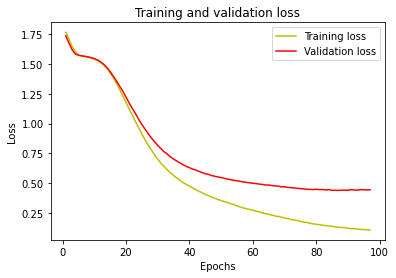

In [ ]:
# Plot the training and validation accuracu and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

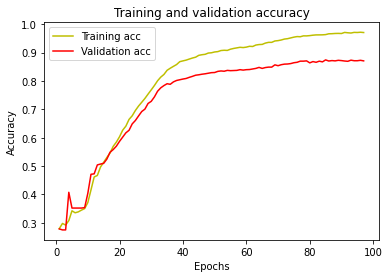

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

3rd step: Transformers models 

In [ ]:
#Un-masked the follwoing code line to allow transformer trainning 
#learner, t = ModelTransformer(model_name = 'bert-base-uncased', categories=['0','1','2','3','4','5'],max_len=64, epochs=2, batch_size=32)     # maxlen: emotion = 64

4th step: DistillBERT

In [ ]:
#Un-masked the follwoing code line to allow transformer trainning 
#learner, t = ModelTransformer('distilbert-base-uncased', categories=['0','1','2','3','4','5'],max_len=64, epochs=2, batch_size=32)     # maxlen: emotion = 64

5th: Distill Roberta to a simpler student


In [ ]:
#Load all Emotion's dataset (only the text sentences)
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

aug_df = load_from_pickle(directory="merged_training.pkl")
x_aug = aug_df.text.values

--2021-04-27 11:43:34--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2021-04-27 11:43:35--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3b8cdf7bda47a0e0d53be2827b.dl.dropboxusercontent.com/cd/0/inline/BNZamyxy5kmut2RFXXkgnmzblai-KnQgYCVUp9ZexDVCdQM7C3K3TCdlqbF1SmDnV5tG4V1guytI9caccnkHaorcjAI0lSMLLBWQmabsvfiQZQd7nCcamKMV2vVSvtqNqCloD6YO9fssHXo1VpfeRxSo/file# [following]
--2021-04-27 11:43:35--  https://uc3b8cdf7bda47a0e0d53be2827b.dl.dropboxusercontent.com/cd/0/inline/BNZamyxy5kmut2RFXXkgnmzblai-KnQgYCVUp9ZexDVCdQM7C3K3TCdlqbF1SmDnV5

Fine-tune RoBERRa and Regenerate x_aug's pseudo labeled data 

In [ ]:
#Option A: Download the pseudo labels of x_aug directly from my GitHub 
y_aug_hotvec = load_from_pickle("/gdrive/My Drive/Blogs/DistillBlog/Emotion/Emotion_Acc9270_y_aug_hotvec.pkl")

#Option B: Un-masked the following code lines to regenerate x_aug's pseudo labels 
### Please note this process takes a while so make sure to reconfigurate your HW resource properly ###
#Trainning Roberta
#learner, t = ModelTransformer('roberta-base', categories=['0','1','2','3','4','5'],max_len=64, epochs=2, batch_size=32)     # maxlen: emotion = 64
#ReGenerate the pseudo labels with Robeera 
#predictor = ktrain.get_predictor(learner.model, t, batch_size=512)
#y_aug_hotvec = predictor.predict_proba(x_aug)

In [ ]:
#Tokenization
aug_padded, test_padded = Tokenizer_Padding(MAX_NUM_WORDS, MAX_LEN, x_aug ,x_test)

In [ ]:
import time 
start = time.time()
acc_list = [] 
for i in range(5):
  model = ModelArch(MAX_NUM_WORDS, MAX_LEN, NUM_CLASS, 'CBOW', EMBEDDING_DIM)
  y_pred_bool, history, saved_model = ModelProcess(aug_padded, test_padded, y_aug_hotvec, EPOCHS, model) 
  acc_list.append(accuracy_score(y_test, y_pred_bool))
  print(accuracy_score(y_test, y_pred_bool))

print(np.average(acc_list))

end = time.time()
print(end - start)

In [ ]:
# Bonus - Distillation with sklearn's MLP Regression (TfIdf based)
from sklearn.neural_network import MLPRegressor
model = make_pipeline(TfidfVectorizer(ngram_range=(1,1), max_features=5000), MLPRegressor(random_state=1, early_stopping=True,hidden_layer_sizes=(16))).fit(x_aug, y_aug_hotvec)
predicted = model.predict(x_test)
y_pred_bool = np.argmax(predicted, axis=1)
print(accuracy_score(y_test, y_pred_bool))
print(classification_report(y_test, y_pred_bool))

0.9225
0.8979764367039851
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       581
           1       0.95      0.93      0.94       695
           2       0.78      0.87      0.82       159
           3       0.91      0.92      0.91       275
           4       0.87      0.93      0.90       224
           5       0.87      0.71      0.78        66

    accuracy                           0.92      2000
   macro avg       0.89      0.88      0.89      2000
weighted avg       0.92      0.92      0.92      2000

